In [1]:
import warnings
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import os
import math
import bisect
import tensorflow as tf

sys.path.insert(0, '../../..')

from cde.density_estimator import GPDExtremeValueMixtureDensityNetwork
from cde.density_estimator import MixtureDensityNetwork
from cde.density_estimator import ExtremeValueMixtureDensityNetwork

from cde.data_collector import MatlabDataset, MatlabDatasetH5, get_most_common_unique_states
from cde.density_estimator import plot_conditional_hist, measure_percentile, measure_percentile_allsame, measure_tail, measure_tail_allsame, init_tail_index_hill, estimate_tail_index_hill
from cde.evaluation.empirical_eval import evaluate_models_singlestate, empirical_measurer, evaluate_model_allstates, evaluate_models_allstates_plot, obtain_exp_value, evaluate_models_allstates_agg


/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/s

In [2]:
""" Load or Create Project """

# name
PROJECT_NAME = 'project_gammagpd_1'

# Path
projects_path = 'saves/projects/'
path = projects_path + PROJECT_NAME + '/'
  
# Get the directory name from the specified path
dirname = os.path.dirname(path)

# create the dir
os.makedirs(dirname, exist_ok=True)


In [7]:
""" import and create the train dataset into Numpy array """

FILE_NAME = 'traindata_gammagpd_A.npz'

file_addr = '../../data/package/train_records_A.mat'
content_key = 'train_records'
select_cols = [0,1,5,9]
batch_size = 1000

training_dataset_A = MatlabDatasetH5(file_address=file_addr,content_key=content_key,select_cols=select_cols)
train_data_A = training_dataset_A.get_data(batch_size)
ndim_x = len(train_data_A[0])-1
meta_info = np.array([batch_size,ndim_x])
np.savez(path + FILE_NAME, train_data, meta_info)

print('train data loaded from .mat files. Rows: %d ' % len(train_data), ' Columns: %d ' % len(train_data[0]), 'ndim_x: %d' % ndim_x)


FILE_NAME = 'traindata_gammagpd_B.npz'

file_addr = '../../data/package/train_records_B.mat'
content_key = 'train_records'

training_dataset_B = MatlabDatasetH5(file_address=file_addr,content_key=content_key,select_cols=select_cols)
train_data_B = training_dataset_B.get_data(batch_size)
ndim_x = len(train_data_B[0])-1
meta_info = np.array([batch_size,ndim_x])
np.savez(path + FILE_NAME, train_data, meta_info)

print('train data loaded from .mat files. Rows: %d ' % len(train_data), ' Columns: %d ' % len(train_data[0]), 'ndim_x: %d' % ndim_x)

 Dataset H5 loaded from .mat file. Rows: 639996   Columns: 4 
train data loaded from .mat files. Rows: 1000   Columns: 4  ndim_x: 3


In [4]:
""" load training data """

FILE_NAME = 'traindata_gammagpd_A.npz'

npzfile = np.load(path + FILE_NAME)
train_data_A = npzfile['arr_0']
meta_info = npzfile['arr_1']
batch_size = meta_info[0]
ndim_x = meta_info[1]

print('training data loaded from .npz file. Rows: %d ' % len(train_data_A), ' Columns: %d ' % len(train_data_A[0]), 'Batch_size: %d' % batch_size, 'ndim_x: %d' % ndim_x)

FILE_NAME = 'traindata_gammagpd_B.npz'

npzfile = np.load(path + FILE_NAME)
train_data_B = npzfile['arr_0']
meta_info = npzfile['arr_1']
batch_size = meta_info[0]
ndim_x = meta_info[1]

print('training data loaded from .npz file. Rows: %d ' % len(train_data_B), ' Columns: %d ' % len(train_data_B[0]), 'Batch_size: %d' % batch_size, 'ndim_x: %d' % ndim_x)

training data loaded from .npz file. Rows: 1000   Columns: 4  Batch_size: 1000 ndim_x: 3
training data loaded from .npz file. Rows: 1000   Columns: 4  Batch_size: 1000 ndim_x: 3


In [5]:
""" import the test dataset A into Numpy array """

FILE_NAME = 'testdata_gammagpd_A.npz'

file_addrs = ['../../data/package/grecords_A1.mat','../../data/package/grecords_A2.mat',
                '../../data/package/grecords_A3.mat','../../data/package/grecords_A4.mat',
                '../../data/package/grecords_A5.mat']

content_keys = ['records_A1','records_A2','records_A3','records_A4',
                    'records_A5']

select_cols = [0,1,5,9]
# define the test packet stream

# 130 seconds each, 15 minutes total
for i in range(len(file_addrs)):
    cond_matds = MatlabDatasetH5(file_address=file_addrs[i],content_key=content_keys[i],select_cols=select_cols)
    if i is 0:
        test_data_A = cond_matds.dataset
    else:
        test_data_A = np.append(test_data_A,cond_matds.dataset,axis=0)

ndim_x_test = len(test_data_A[0])-1

meta_info = np.array([ndim_x_test])
np.savez(projects_path + FILE_NAME, test_data, meta_info)

print('test data loaded from .mat files. Rows: %d ' % len(test_data), ' Columns: %d ' % len(test_data[0]), 'ndim_x: %d' % ndim_x_test)

 Dataset H5 loaded from .mat file. Rows: 87999652   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999624   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999640   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999645   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999620   Columns: 4 
test data loaded from .mat files. Rows: 439998181   Columns: 4  ndim_x: 3


In [14]:
""" import the test dataset B into Numpy array """

FILE_NAME = 'testdata_gammagpd_B.npz'

file_addrs = ['../../data/package/grecords_B1.mat','../../data/package/grecords_B2.mat',
                '../../data/package/grecords_B3.mat','../../data/package/grecords_B4.mat',
                '../../data/package/grecords_B5.mat']

content_keys = ['records_B1','records_B2','records_B3','records_B4',
                    'records_B5']

select_cols = [0,1,5,9]
# define the test packet stream

# 130 seconds each, 15 minutes total
for i in range(len(file_addrs)):
    cond_matds = MatlabDatasetH5(file_address=file_addrs[i],content_key=content_keys[i],select_cols=select_cols)
    if i is 0:
        test_data_B = cond_matds.dataset
    else:
        test_data_B = np.append(test_data_B,cond_matds.dataset,axis=0)

ndim_x_test = len(test_data_B[0])-1

meta_info = np.array([ndim_x_test])
np.savez(projects_path + FILE_NAME, test_data_B, meta_info)

print('test data loaded from .mat files. Rows: %d ' % len(test_data_B), ' Columns: %d ' % len(test_data_B[0]), 'ndim_x: %d' % ndim_x_test)

 Dataset H5 loaded from .mat file. Rows: 87999605   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999564   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999587   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999596   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999605   Columns: 4 


NameError: name 'test_data' is not defined

In [10]:
""" load the test datasets """

FILE_NAME = 'testdata_gammagpd_A.npz'

npzfile = np.load(projects_path + FILE_NAME)
test_data_A = npzfile['arr_0']
meta_info = npzfile['arr_1']
ndim_x_test = meta_info[0]

print('test data loaded from .npz file. Rows: %d ' % len(test_data_A), ' Columns: %d ' % len(test_data_A[0]), 'ndim_x: %d' % ndim_x_test)

FILE_NAME = 'testdata_gammagpd_B.npz'

npzfile = np.load(projects_path + FILE_NAME)
test_data_B = npzfile['arr_0']
meta_info = npzfile['arr_1']
ndim_x_test = meta_info[0]

print('test data loaded from .npz file. Rows: %d ' % len(test_data_B), ' Columns: %d ' % len(test_data_B[0]), 'ndim_x: %d' % ndim_x_test)


test data loaded from .npz file. Rows: 703997456   Columns: 4  ndim_x: 3


In [11]:
""" create models and train them """

n_epoch_emm = 8000
n_epoch_gmm = 5000
FILE_NAME = 'est_models.pkl'

Y = train_data_A[:,0]
X = train_data_A[:,1:]

model_1 = GPDExtremeValueMixtureDensityNetwork("EMM_A", ndim_x=ndim_x, n_centers=3, ndim_y=1, n_training_epochs=n_epoch_emm, hidden_sizes=(16, 16),verbose_step=math.floor(n_epoch_emm/10), weight_decay=1e-4, learning_rate=1e-4,epsilon=1e-6)
model_1.fit(X, Y)

model_2 = MixtureDensityNetwork("GMM_A", ndim_x=ndim_x, n_centers=10, ndim_y=1,n_training_epochs=n_epoch_gmm,hidden_sizes=(32, 32))
model_2.fit(X, Y)

Y = train_data_B[:,0]
X = train_data_B[:,1:]

model_3 = GPDExtremeValueMixtureDensityNetwork("EMM_B", ndim_x=ndim_x, n_centers=3, ndim_y=1, n_training_epochs=n_epoch_emm, hidden_sizes=(16, 16),verbose_step=math.floor(n_epoch_emm/10),weight_decay=1e-4, learning_rate=1e-4,epsilon=1e-6)
model_3.fit(X, Y)

model_4 = MixtureDensityNetwork("GMM_B", ndim_x=ndim_x, n_centers=10, ndim_y=1,n_training_epochs=n_epoch_gmm,hidden_sizes=(32, 32))
model_4.fit(X, Y)


models = [model_1,model_2,model_3,model_4]
with open(path + FILE_NAME, 'wb') as output:
    pickle.dump(models, output, pickle.HIGHEST_PROTOCOL)


Step 0: train log-likelihood 4076.9546, eval log-likelihood 0
Step 800: train log-likelihood 2946.747, eval log-likelihood 0
Step 1600: train log-likelihood 2479.3083, eval log-likelihood 0
Step 2400: train log-likelihood 2029.1023, eval log-likelihood 0
Step 3200: train log-likelihood 1766.7615, eval log-likelihood 0
Step 4000: train log-likelihood 1659.1206, eval log-likelihood 0
Step 4800: train log-likelihood 1563.8481, eval log-likelihood 0
Step 5600: train log-likelihood 1512.5974, eval log-likelihood 0
Step 6400: train log-likelihood 1467.1849, eval log-likelihood 0
Step 7200: train log-likelihood 1439.1394, eval log-likelihood 0
Step 8000: train log-likelihood 1421.3357, eval log-likelihood 0
5000/5000 [100%] ██████████████████████████████ Elapsed: 119s | loss: 436.780
mean log-loss train: 0.4368
Step 0: train log-likelihood 3991.4146, eval log-likelihood 0
Step 800: train log-likelihood 2462.9111, eval log-likelihood 0
Step 1600: train log-likelihood 2057.4238, eval log-likeli

In [4]:
""" load trained models """

FILE_NAME = 'est_models.pkl'

with open(path+FILE_NAME, 'rb') as input:
    sess = tf.Session()
    with sess:
        d_models = pickle.load(input)

model_1 = d_models[0]
model_1._setup_inference_and_initialize()

model_2 = d_models[1]
model_2._setup_inference_and_initialize()

model_3 = d_models[2]
model_3._setup_inference_and_initialize()

model_4 = d_models[3]
model_4._setup_inference_and_initialize()

n_epoch = model_1.n_training_epochs

print(d_models)
print('n_epoch: %d'%n_epoch)


[GPDExtremeValueMixtureDensityNetwork(epsilon=1e-06, hidden_sizes=(32, 32),
                                     learning_rate=0.0001,
                                     n_training_epochs=10000, name='EMM_GPD',
                                     ndim_x=3, ndim_y=1, verbose_step=1000,
                                     x_noise_std=0.0, y_noise_std=0.0), MixtureDensityNetwork(hidden_sizes=(32, 32), n_training_epochs=10000,
                      name='GMM', ndim_x=3, ndim_y=1, x_noise_std=0.0,
                      y_noise_std=0.0), ExtremeValueMixtureDensityNetwork(hidden_sizes=(32, 32), learning_rate=0.001,
                                  n_training_epochs=10000, name='EMM_PL',
                                  ndim_x=3, ndim_y=1, verbose_step=1000,
                                  x_noise_std=0.0, y_noise_std=0.0)]
n_epoch: 10000


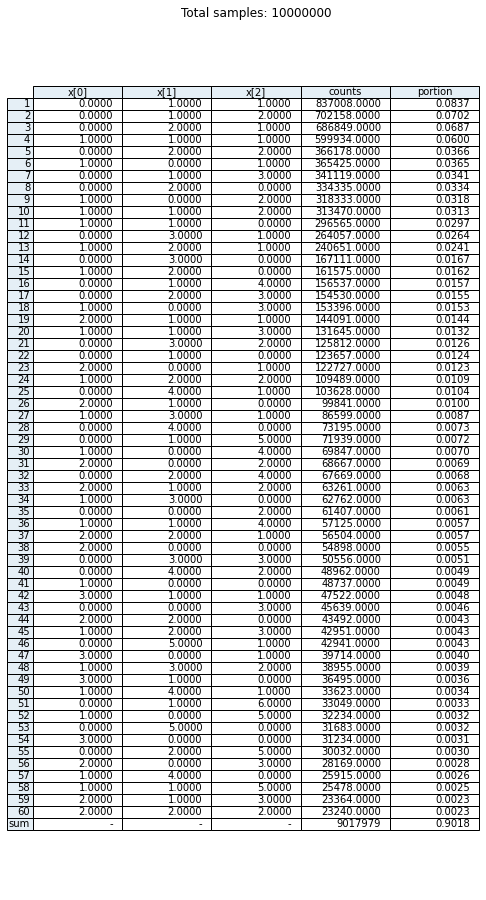

In [16]:
""" Find most common states in the test_data """

unique_states_A,_,_ = get_most_common_unique_states(test_data_A[:10000000,:],ndim_x=3,N=60,plot=True)
unique_states_B,_,_ = get_most_common_unique_states(test_data_B[:10000000,:],ndim_x=3,N=60,plot=True)

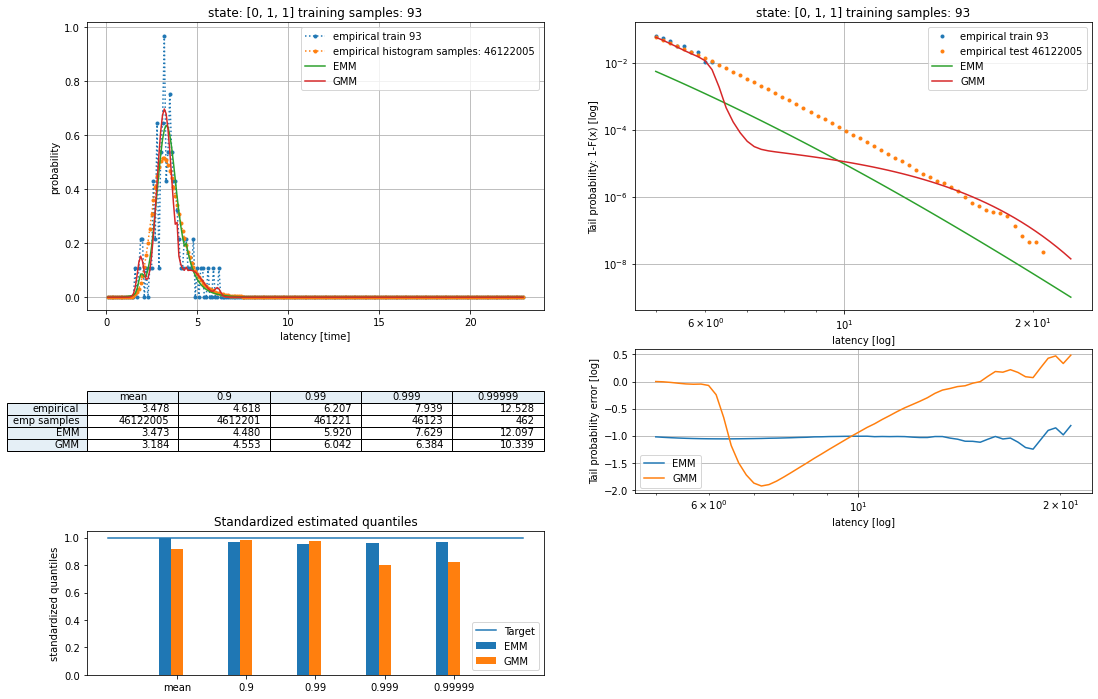

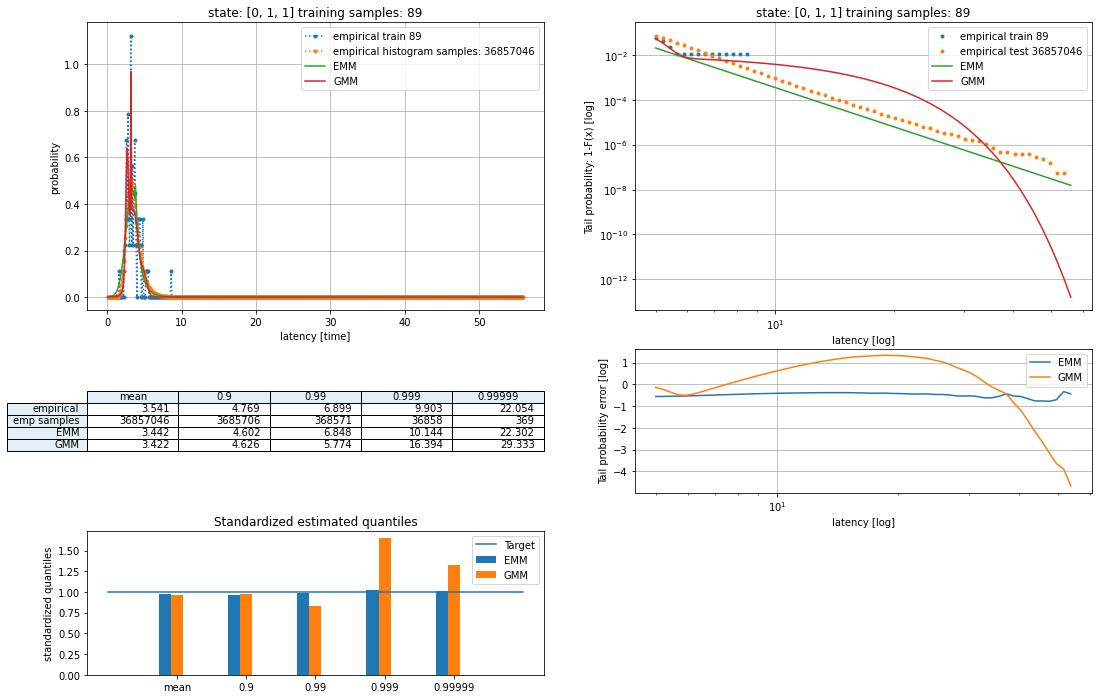

In [17]:
""" Benchmark models on single states """

import warnings
warnings.filterwarnings('ignore')

evaluate_models_singlestate(models=[model_1,model_2],model_names=["EMM","GMM"],train_data=train_data_A,cond_state=[0,1,1],test_dataset=test_data_A,quantiles=[1-1e-1,1-1e-2,1-1e-3,1-1e-5])
evaluate_models_singlestate(models=[model_3,model_4],model_names=["EMM","GMM"],train_data=train_data_B,cond_state=[0,1,1],test_dataset=test_data_B,quantiles=[1-1e-1,1-1e-2,1-1e-3,1-1e-5])


In [21]:
""" Benchamrk the models upon all the states """
""" Requirements: models, emp_model, test_data, ndim_x_test, and unique_states """

FILE_NAME = 'benchmark_allstate.npz'

quantiles = [0.9, 0.99, 0.999, 0.9999, 0.99999] #quantiles = [0.9, 0.99, 0.999, 0.9999, 0.99999]
xsize = ndim_x_test
N=60 # N=60
emp_model_A = empirical_measurer(dataset=test_data_A,xsize=xsize,quantiles=quantiles)
emp_model_B = empirical_measurer(dataset=test_data_B,xsize=xsize,quantiles=quantiles)

# warning - takes 1 hour
# the first model treats with .tail_inverse, the rest with find_perc
# N=60, len(quantiles)=5, 1.5 hour

eval_results = np.empty((0,N,xsize+(len(quantiles))+1))
# EMM_A
results_1 = evaluate_model_allstates(emp_model=emp_model_A,model=model_1,train_data=train_data_A,unique_states=unique_states_A,N=N,quantiles=quantiles,xsize=xsize,root_find=False)
eval_results = np.append(eval_results,[results_1],axis=0)

# GMM_A
results_2 = evaluate_model_allstates(emp_model=emp_model_A,model=model_2,train_data=train_data_A,unique_states=unique_states_A,N=N,quantiles=quantiles,xsize=xsize,root_find=True)
eval_results = np.append(eval_results,[results_2],axis=0)

# EMM_B
results_3 = evaluate_model_allstates(emp_model=emp_model_B,model=model_3,train_data=train_data_B,unique_states=unique_states_B,N=N,quantiles=quantiles,xsize=xsize,root_find=False)
eval_results = np.append(eval_results,[results_3],axis=0)

# GMM_B
results_4 = evaluate_model_allstates(emp_model=emp_model_B,model=model_4,train_data=train_data_B,unique_states=unique_states_B,N=N,quantiles=quantiles,xsize=xsize,root_find=True)
eval_results = np.append(eval_results,[results_4],axis=0)


# save the results into a file
meta_info = np.array([xsize,N])
quantiles_info = np.array(quantiles)
np.savez(path + FILE_NAME, meta_info, quantiles_info, emp_model_A.database, emp_model_B.database, results_1, results_2, results_3, results_4)

In [52]:
""" Load the benchamrk results of the models upon all the states """

FILE_NAME = 'benchmark_allstate.npz'

npzfile = np.load(path + FILE_NAME)
meta_info = npzfile['arr_0']
quantiles = npzfile['arr_1']
xsize = meta_info[0]
N = meta_info[1]

#emp_model = empirical_measurer(dataset=test_data,xsize=xsize,quantiles=quantiles)
#emp_model.database = npzfile['arr_2']

#eval_results_1 = np.empty((0,N,xsize+(len(quantiles))+1))
emm1_results_p = npzfile['arr_3']
#eval_results_1 = np.append(eval_results_1,[emm1_results],axis=0)
emm2_results_p = npzfile['arr_4']
#eval_results_1 = np.append(eval_results_1,[gmm_results],axis=0)
emm3_results_p = npzfile['arr_5']
emm4_results_p = npzfile['arr_6']
#eval_results_1 = np.append(eval_results_1,[pmm_results],axis=0)

print('benchmark allstate loaded from .npz file. Models: %d ' % len(eval_results), ' n_states(N): %d ' % len(eval_results[0]), 'xsize: %d' % xsize)

benchmark allstate loaded from .npz file. Models: 4   n_states(N): 10  xsize: 3


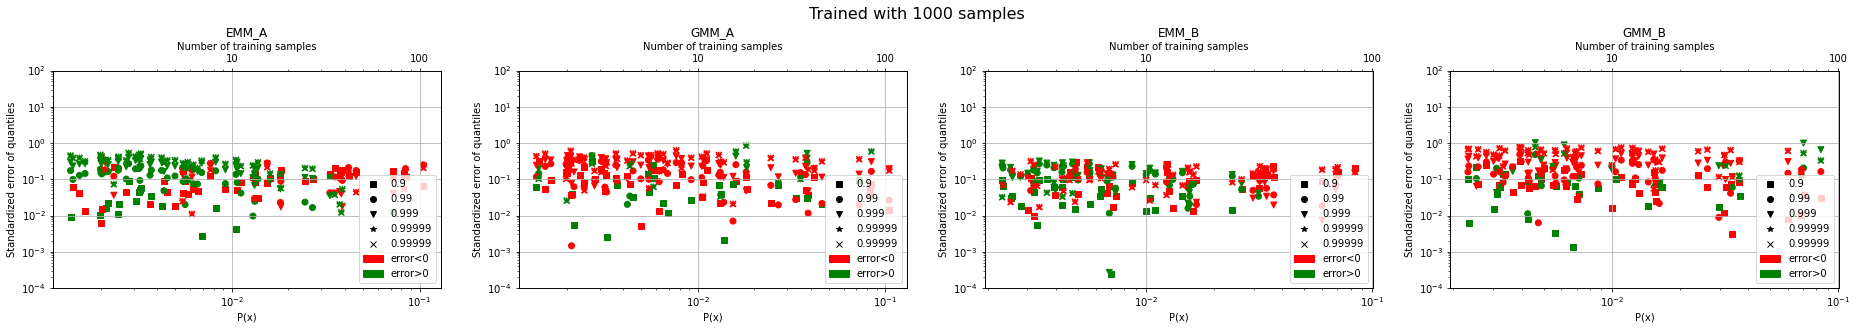

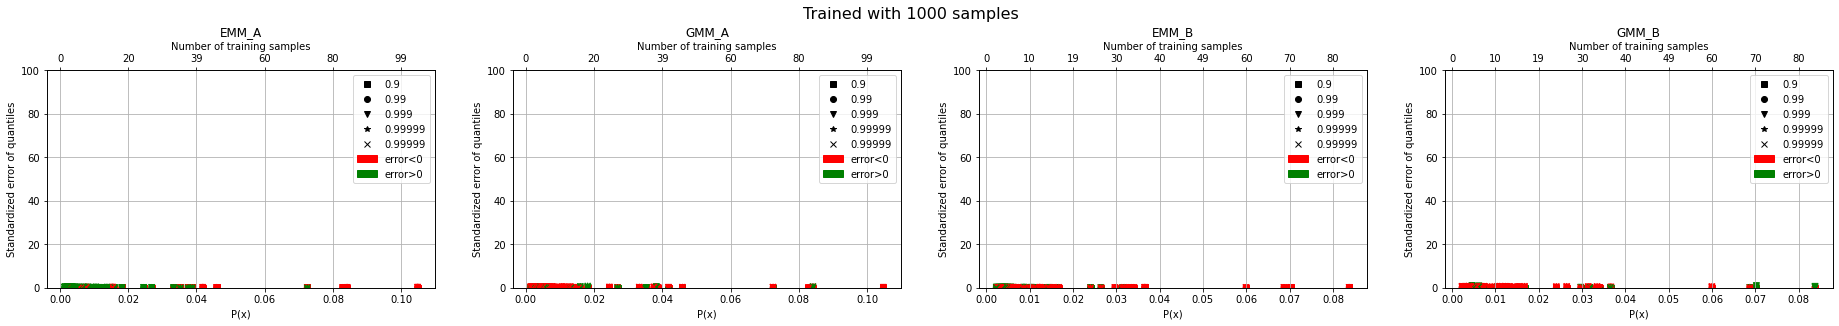

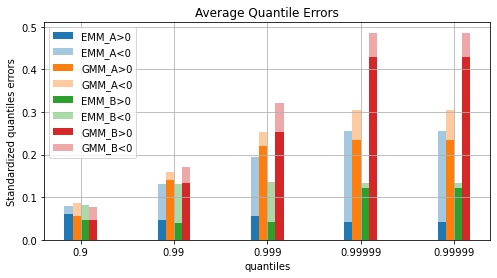

In [22]:
evaluate_models_allstates_plot(cma_results=eval_results,train_len=len(train_data_A),model_names=['EMM_A','GMM_A','EMM_B','GMM_B'],quantiles=quantiles,markers=['s','o','v','*','x'],loglog=True,ylim_ll=[1e-4,1e2])
evaluate_models_allstates_plot(cma_results=eval_results,train_len=len(train_data_A),model_names=['EMM_A','GMM_A','EMM_B','GMM_B'],quantiles=quantiles,markers=['s','o','v','*','x'],loglog=False,ylim=[0,100])
evaluate_models_allstates_agg(cma_results=eval_results,train_len=len(train_data_A),n_epoch=n_epoch_emm,xsize=xsize,quantiles=quantiles,model_names=['EMM_A','GMM_A','EMM_B','GMM_B'])